# Загрузка файлов

In [2]:
from google.colab import files
uploaded = files.upload()

Saving video games sales.csv to video games sales.csv


# ***Задача 1. Обнаружение фальшивых новостей***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB
              precision    recall  f1-score   support

        FAKE       0.93      0.94      0.93       794
        REAL       0.94      0.93      0.93       790

    accuracy                           0.93      1584
   macro avg       0.93      0.93      0.93      1584
weighted avg       0.93      0.93      0.93      1584



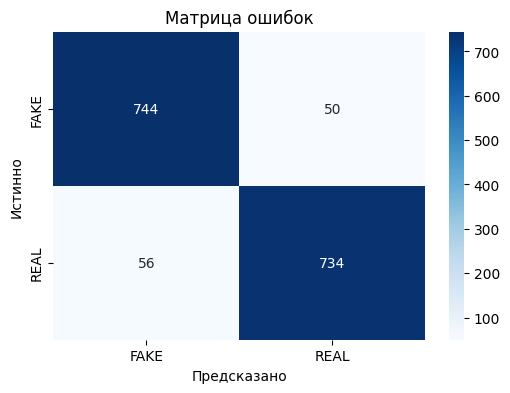

In [ ]:
# --- Импорт библиотек ---

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix, classification_report

# --- Загрузка и первичный анализ данных ---

df = pd.read_csv('fake_news.csv')

df.info()
df['label'].value_counts()

# Проверили, сколько строк и столбцов в датасете.
# Убедились, что пропущенных значений нет.
# Видим, что классы REAL и FAKE сбалансированы.

# --- Очистка текста ---

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)                 # удаляем числа
    text = re.sub(r'[^\w\s]', '', text)             # удаляем пунктуацию
    text = ' '.join([word for word in text.split()
                                    if word not in ENGLISH_STOP_WORDS])
    return text

# Привели текст к нижнему регистру.
# Удалили цифры, пунктуацию и стоп-слова.

# --- Подготовка данных ---

df['content'] = (df['title'] + ' ' + df['text']).apply(clean_text)

X = df['content']
Y = df['label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25,
                                                    random_state = 42)

# Объединили заголовок и текст в один признак content.
# Разбили данные на обучающую и тестовую выборки.

# --- Преобразование текста с помощью TfidfVectorizer ---

vectorize = TfidfVectorizer()
X_train_tfidf = vectorize.fit_transform(X_train)
X_test_tfidf = vectorize.transform(X_test)

# Использовали TfidfVectorizer для преобразования текста в числовой формат.

# --- Обучение модели ---

PAC = PassiveAggressiveClassifier(max_iter=1000)
PAC.fit(X_train_tfidf, Y_train)

# Используем алгоритм PassiveAggressiveClassifier, подходящий для текстовой классификации.

# --- Предсказание ---

y_pred = PAC.predict(X_test_tfidf)

# --- Матрица ошибок и отчёт ---

cm = confusion_matrix(Y_test, y_pred)
print(classification_report(Y_test, y_pred))

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Предсказано')
plt.ylabel('Истинно')
plt.title('Матрица ошибок')
plt.show()

# Модель показывает точность 93%, с равномерной производительностью по всем метрикам.
# Матрица ошибок визуализирует, где происходят ошибки классификации.

***Вывод***
---

* Модель эффективно отличает фейковые новости от настоящих.
* Очистка текста улучшает интерпретируемость данных, хотя точность осталась на том же уровне.

# ***Задача 2. Обнаружение болезни паркинсона с помощью XGBoost***

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшая конфигурация: {'colsample_bytree': 0.75, 'learning_rate': 0.15, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 150, 'subsample': 0.85}
Точность на тестовой выборке: 0.9487179487179487
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.94      1.00      0.97        32

    accuracy                           0.95        39
   macro avg       0.97      0.86      0.90        39
weighted avg       0.95      0.95      0.95        39



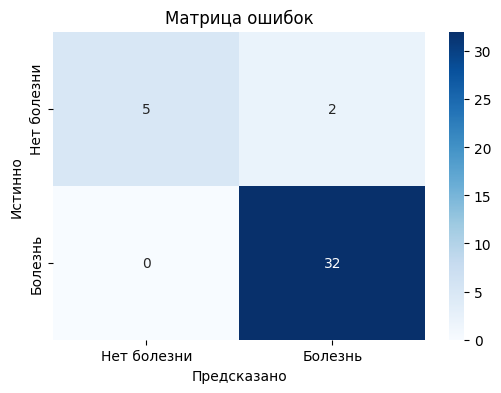

In [ ]:
# --- Импорт библиотек ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier

# --- Параметры для обучения ---

PARAMS = {
    'n_estimators': [150, 200],              # Кол-во деревьев
    'max_depth': [2, 3, 4],                  # Глубина дерева
    'learning_rate': [0.1, 0.15],            # Темп обучения
    'subsample': [0.85],                     # Подвыборка объектов
    'colsample_bytree': [0.75, 0.8, 0.85],   # Подвыборка признаков
    'min_child_weight': [1, 3]               # Минимальное число выборок в узле
}

# --- Загрузка и первичный анализ данных ---

df = pd.read_csv('parkinsons.data')
df.head()

# --- Подготовка данных ---

x = df.drop(columns=['name', 'status'])
y = df['status']

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.2,
                                                    random_state=42)

# --- Обучение модели ---

model = XGBClassifier(eval_metric = 'logloss')
grid = GridSearchCV(model, param_grid = PARAMS, cv = 5, scoring='accuracy',
                    verbose = 1, n_jobs = -1)
grid.fit(x_train,y_train)

best_model = grid.best_estimator_
print("Лучшая конфигурация:", grid.best_params_)

# --- Предсказание ---

y_pred = best_model.predict(x_test)

# --- Матрица ошибок и отчёт ---

acc = accuracy_score(y_test, y_pred)
print("Точность на тестовой выборке:", acc)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Нет болезни', 'Болезнь'],
            yticklabels=['Нет болезни', 'Болезнь'])
plt.xlabel('Предсказано')
plt.ylabel('Истинно')
plt.title('Матрица ошибок')
plt.show()

***Вывод***
---
Модель на основе алгоритма XGBoost показала **высокую** эффективность в задаче классификации болезни Паркинсона.

***--- Качество модели ---***

* Точность на тестовой выборке: 94.87%
* F1-score (болезнь): 0.97 — высокий показатель сбалансированной точности и полноты.
* Recall (болезнь): 1.00 — модель не пропустила ни одного больного пациента, что критически важно для медицинских задач.
* Precision (болезнь): 0.94 — почти все предсказания болезни были верными.

***--- Матрица ошибок ---***

Из 39 тестовых образцов:
* 32 случая болезни предсказаны правильно.
* 5 здоровых распознаны верно.
* 2 здоровых человека ошибочно классифицированы как больные.
* 0 больных классифицированы как здоровые — это главный успех модели.

***--- Лучшие гиперпараметры ---***
* n_estimators: 150
* max_depth: 2
* learning_rate: 0.15
* subsample: 0.85
* colsample_bytree: 0.75
* min_child_weight: 1
* gamma: 0

***Итог***
---
Модель демонстрирует *высокую надёжность* и *медицинскую пригодност*ь. Она
идеально подходит как автоматизированный помощник для раннего выявления болезни Паркинсона, минимизируя риски пропуска заболевания.

# ***Задача 3. Творческая. Предсказать продажи видеоигр***

   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  
Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float

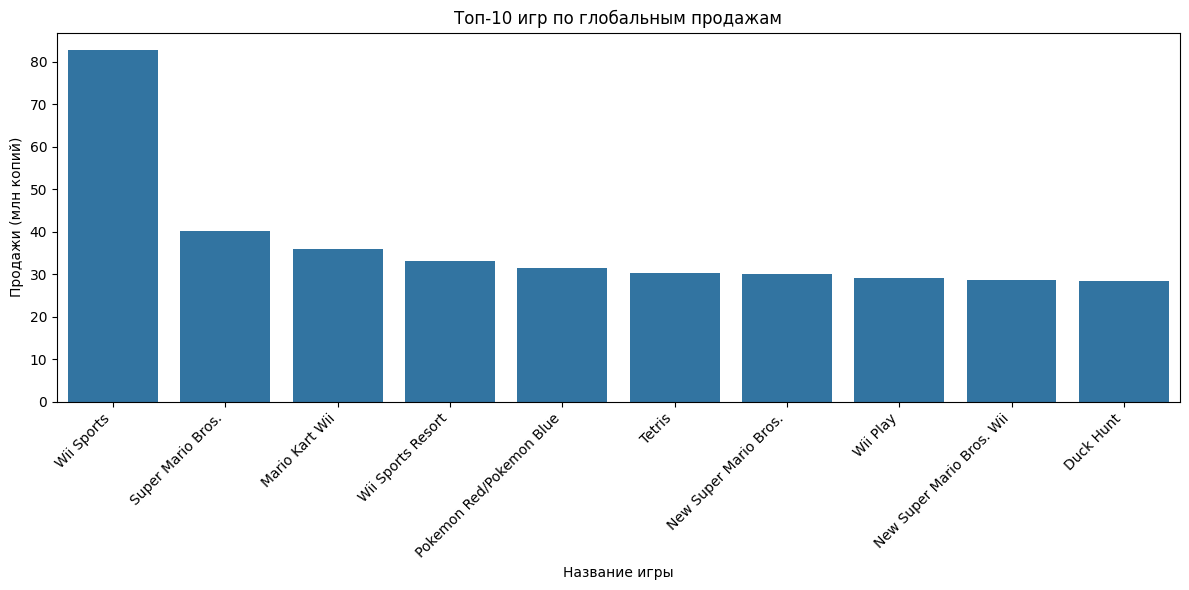

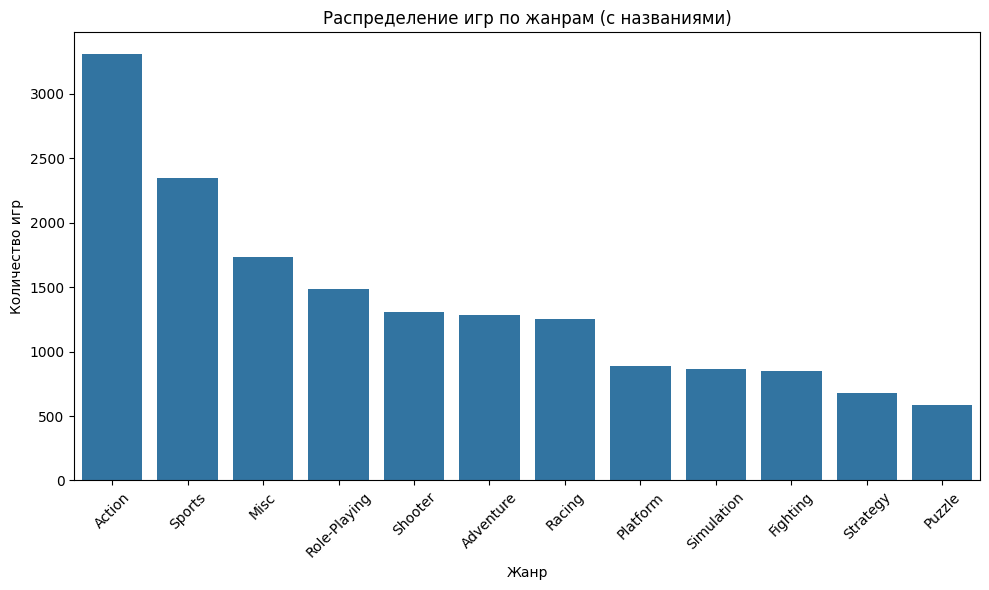

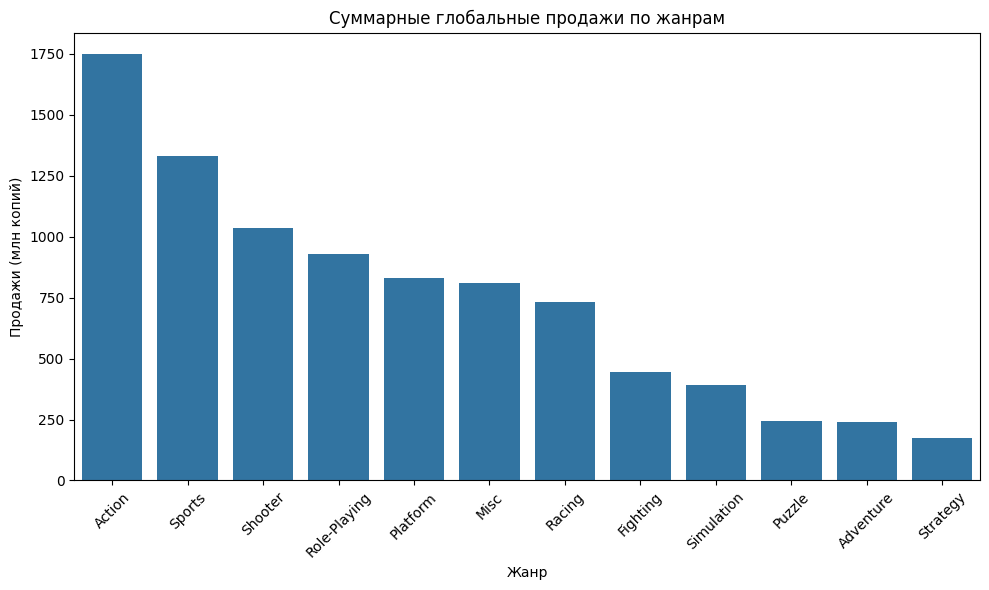

<ipython-input-20-37c02516fe88>:97: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=platform_sales.index, y=platform_sales.values, palette='viridis')


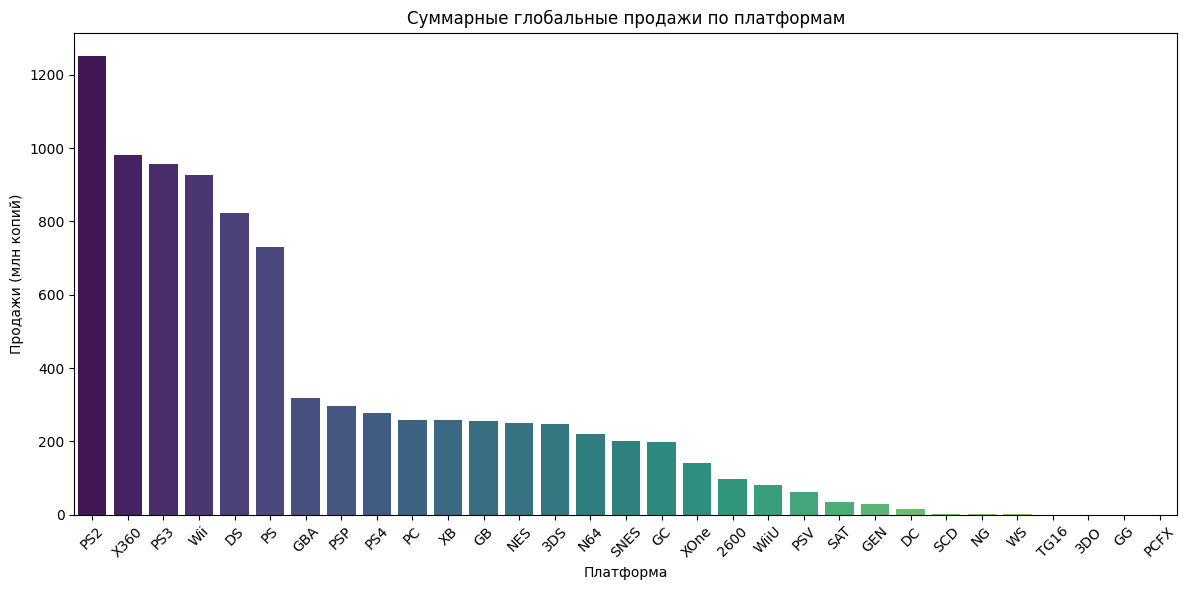

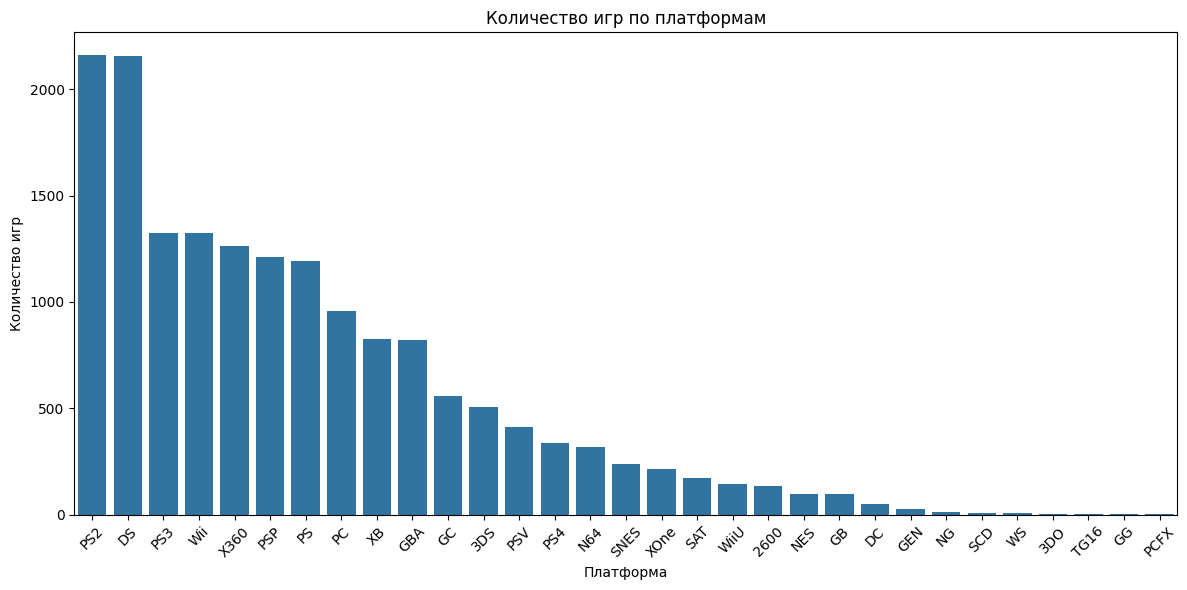

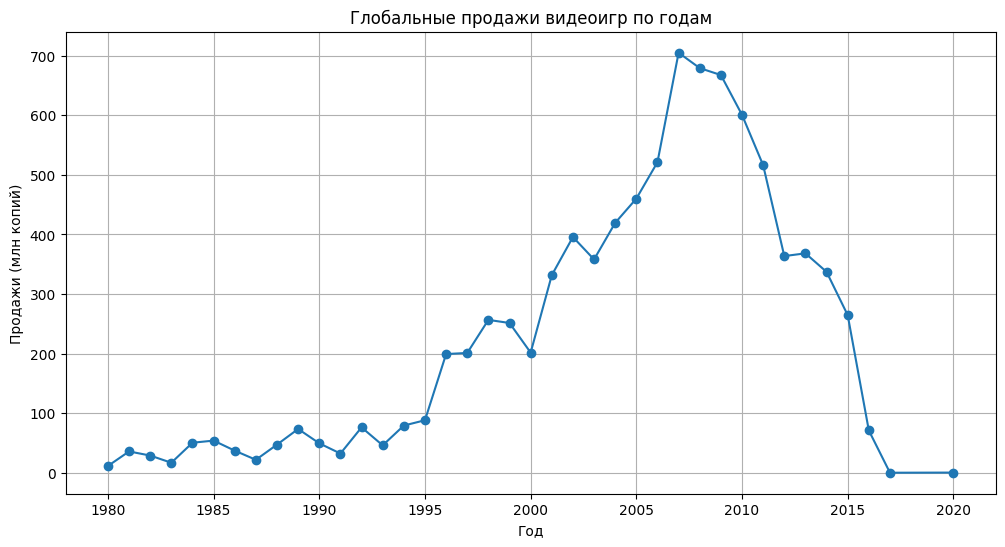

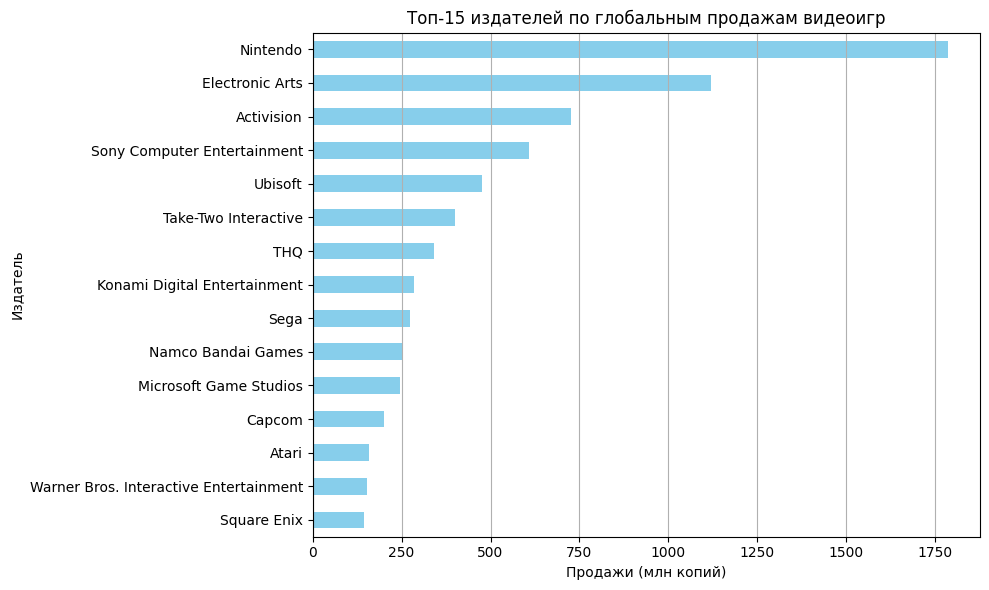

0.26485219594594595 0.1467109073359073 0.07783059845559845 0.04809242277992278
Среднеквадратичная ошибка (MSE): 0.84
Коэффициент детерминации (R²): 0.80


<ipython-input-20-37c02516fe88>:217: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_importances, y=sorted_features, palette="viridis")


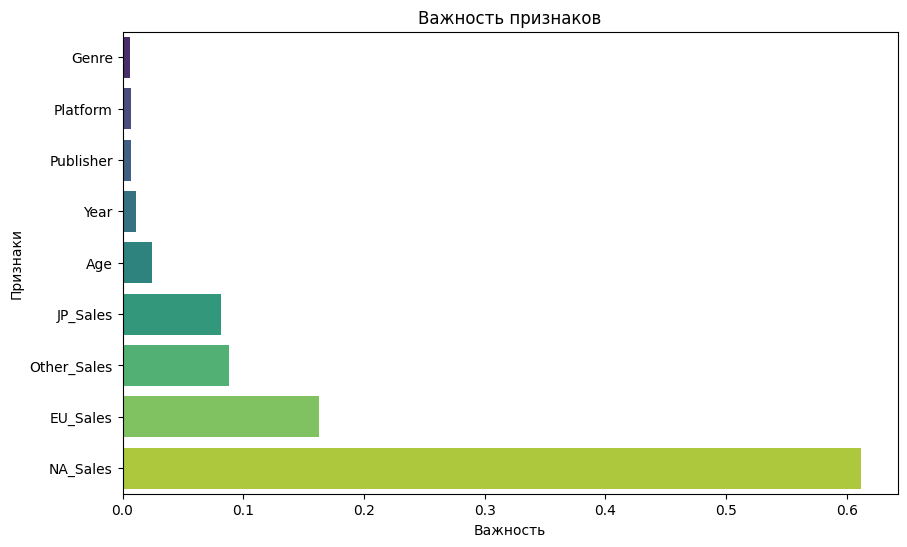

R² на каждой итерации: [0.79973891 0.9660331  0.98557559 0.90448211 0.96835014]
Среднее R²: 0.9248359700103013


['label_encoders.pkl']

In [20]:
# ------------------------------------------
#             Импорт библиотек
# ------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (train_test_split, cross_val_score,
                                       ShuffleSplit, RandomizedSearchCV)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBRegressor

# ------------------------------------------
#     Загрузка и первичный анализ данных
# ------------------------------------------
df = pd.read_csv('video games sales.csv')

print(df.head())
print(df.dtypes)
print(df.info())
print(df.isnull().sum())

# ------------------------------------------
#             Подготовка данных
# ------------------------------------------
# Удаляем строки, где одновременно нет года и издателя
df = df[~(df['Year'].isnull() & df['Publisher'].isnull())]

# Заполняем оставшиеся пропуски
df['Year'] = df['Year'].fillna(df['Year'].median())
df['Publisher'] = df['Publisher'].fillna(df['Publisher'].mode()[0])

# Кодируем категориальные признаки
label_encoders = {}
for column in ['Platform', 'Genre', 'Publisher']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# ------------------------------------------
#             Графики и анализ
# ------------------------------------------
# Топ-10 игр по глобальным продажам
top10 = df.sort_values('Global_Sales', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x='Name', y='Global_Sales')
plt.xticks(rotation=45, ha='right')
plt.title('Топ-10 игр по глобальным продажам')
plt.ylabel('Продажи (млн копий)')
plt.xlabel('Название игры')
plt.tight_layout()
plt.show()

# Распределение игр по жанрам
genre_le = label_encoders['Genre']
genre_mapping = (dict(zip(genre_le.transform(genre_le.classes_),
                          genre_le.classes_)))
df['Genre_name'] = df['Genre'].map(genre_mapping)

plt.figure(figsize=(10, 6))
sns.countplot(x='Genre_name', data=df, order=df['Genre_name']
              .value_counts().index)
plt.xticks(rotation=45)
plt.title('Распределение игр по жанрам (с названиями)')
plt.xlabel('Жанр')
plt.ylabel('Количество игр')
plt.tight_layout()
plt.show()

# Суммарные глобальные продажи по жанрам
genre_sales = (df.groupby('Genre_name')['Global_Sales']
               .sum().sort_values(ascending=False))

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_sales.index, y=genre_sales.values)
plt.xticks(rotation=45)
plt.title('Суммарные глобальные продажи по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Продажи (млн копий)')
plt.tight_layout()
plt.show()

# Суммарные глобальные продажи по платформам
platform_le = label_encoders['Platform']
platform_mapping = dict(zip(platform_le.transform(platform_le.classes_),
                            platform_le.classes_))
df['Platform_name'] = df['Platform'].map(platform_mapping)

platform_sales = (df.groupby('Platform_name')['Global_Sales']
                  .sum().sort_values(ascending=False))

plt.figure(figsize=(12, 6))
sns.barplot(x=platform_sales.index, y=platform_sales.values, palette='viridis')
plt.title('Суммарные глобальные продажи по платформам')
plt.xlabel('Платформа')
plt.ylabel('Продажи (млн копий)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Количество игр по платформам
platform_counts = df['Platform_name'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(x=platform_counts.index, y=platform_counts.values)
plt.title('Количество игр по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество игр')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Глобальные продажи видеоигр по годам
year_sales = df.groupby('Year')['Global_Sales'].sum()

plt.figure(figsize=(12, 6))
plt.plot(year_sales.index, year_sales.values, marker='o')
plt.title('Глобальные продажи видеоигр по годам')
plt.xlabel('Год')
plt.ylabel('Продажи (млн копий)')
plt.grid(True)
plt.show()

# Топ-15 издателей по глобальным продажам
publisher_le = label_encoders['Publisher']
publisher_mapping = dict(zip(publisher_le.transform(publisher_le.classes_),
                             publisher_le.classes_))
df['Publisher_name'] = df['Publisher'].map(publisher_mapping)

top_publishers = (df.groupby('Publisher_name')['Global_Sales']
                  .sum().sort_values(ascending=False).head(15))

plt.figure(figsize=(10, 6))
top_publishers.sort_values().plot(kind='barh', color='skyblue')
plt.title('Топ-15 издателей по глобальным продажам видеоигр')
plt.xlabel('Продажи (млн копий)')
plt.ylabel('Издатель')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

# ------------------------------------------
#    Подготовка данных к обучению модели
# ------------------------------------------

# Добавляем новый столбец Age
df['Age'] = 2017 - df['Year']

# Выбираем признаки и целевую переменную
# Только жанр, платформа, издатель, год, возраст
X = df[['Genre', 'Platform', 'Publisher', 'Year', 'Age', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
y = df['Global_Sales']


# Стандартизация числовых признаков
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']] = scaler.fit_transform(
    X_scaled[['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']]
)

# Разделение на обучающую и тестовую выборку
x_train, x_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)



# ------------------------------------------
#              Обучение модели
# ------------------------------------------

na_sales_mean = df['NA_Sales'].mean()
eu_sales_mean = df['EU_Sales'].mean()
jp_sales_mean = df['JP_Sales'].mean()
other_sales_mean = df['Other_Sales'].mean()

print(na_sales_mean, eu_sales_mean, jp_sales_mean, other_sales_mean)

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=400,
    learning_rate=0.1,
    max_depth=7,
    subsample=1.0,
    colsample_bytree=0.7,
    random_state=42
)

model.fit(x_train, y_train)

# Предсказание и оценка качества
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Среднеквадратичная ошибка (MSE): {mse:.2f}")
print(f"Коэффициент детерминации (R²): {r2:.2f}")

# ------------------------------------------
#         Оценка важности признаков
# ------------------------------------------

importances = model.feature_importances_
feature_names = X.columns

sorted_idx = np.argsort(importances)
sorted_features = np.array(feature_names)[sorted_idx]
sorted_importances = importances[sorted_idx]

plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_features, palette="viridis")
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.title('Важность признаков')
plt.show()

# ------------------------------------------
#              Кросс-валидация
# ------------------------------------------

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
scores = cross_val_score(model, X_scaled, y, cv=cv, scoring='r2')

print("R² на каждой итерации:", scores)
print("Среднее R²:", np.mean(scores))

# ------------------------------------------
#         Сохраняем модель и объекты
# ------------------------------------------

# Сохраняем модель
joblib.dump(best_model, 'xgb_model.pkl')

# Сохраняем scaler
joblib.dump(scaler, 'scaler.pkl')

# Сохраняем label_encoders
joblib.dump(label_encoders, 'label_encoders.pkl')

In [7]:
pip install streamlit
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


Создан файл app.py, в котором создано Streamlit-приложение
---

In [17]:
!curl https://loca.lt/mytunnelpassword

34.148.195.0

In [22]:
!streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.148.195.0:8501

⠼⠴⠦your url is: https://olive-taxes-check.loca.lt
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
  Stopping...
^C
